# 나이브 베이즈 분류기 (Navie Bayes Classification)

* 베이즈 정리를 적용한 확률적 분류 알고리즘
* 모든 특성들이 독립임을 가정 (naive 가정)
* 입력 특성에 따라 3개의 분류기 존재
  1. 가우시안 나이브 베이즈 분류기
  2. 베르누이 나이브 베이즈 분류기
  3. 다항 나이브 베이즈 분류기


# 나이브 베이즈 분류기의 확률 모델

* 나이브 베이즈는 조건부 확률 모델
* N개의 특성을 나타내는 벡터 x를 입력으로 받아 k개의 가능한 확률적 결과를 출력
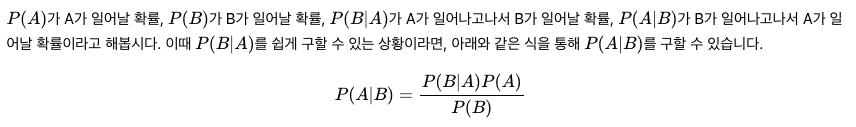

* 분자만이 출력 값에 영향을 받기 때문에 분모 부분을 상수로 취급할 수 있음
* 나이브 베이즈 분류기는 모든 특성이 독립이라고 가정하기 때문에 다음과 같이 쓸 수 있음
* 다음 식을 통해 나온 값들 중 max값을 갖는 클래스가 예측 결과.
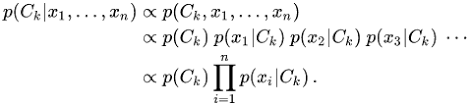


In [115]:
import numpy as np
import pandas as pd

# 나이브 베이즈 3가지 분류기 모델 import
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
# 산림토양, 뉴스 데이터 import
from sklearn.datasets import fetch_covtype, fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

In [3]:
prior = [0.45, 0.3, 0.15, 0.1] # p(Ck)
likelihood = [[0.3, 0.3, 0.4], [0.7, 0.2, 0.1], [0.15, 0.5, 0.35], [0.6, 0.2 ,0.2]]

# 각각의 클래스에 대해서 가능성 계산
idx = 0
for c, xs in zip(prior, likelihood) : 
    result = 1.

    for x in xs : 
        result *= x
    result *= c
    idx+=1
    print(f"{idx}번째 클래스의 가능성 : {result}")

1번째 클래스의 가능성 : 0.0162
2번째 클래스의 가능성 : 0.0042
3번째 클래스의 가능성 : 0.0039375
4번째 클래스의 가능성 : 0.0024000000000000002


# 산림 토양 데이터

* 산림 지역 토양의 특징 데이터
* 토양이 어떤 종류에 속하는지 예측

In [4]:
covtype = fetch_covtype()
print(covtype.DESCR)

.. _covtype_dataset:

Forest covertypes
-----------------

The samples in this dataset correspond to 30×30m patches of forest in the US,
collected for the task of predicting each patch's cover type,
i.e. the dominant species of tree.
There are seven covertypes, making this a multiclass classification problem.
Each sample has 54 features, described on the
`dataset's homepage <https://archive.ics.uci.edu/ml/datasets/Covertype>`__.
Some of the features are boolean indicators,
while others are discrete or continuous measurements.

**Data Set Characteristics:**

    =================   ============
    Classes                        7
    Samples total             581012
    Dimensionality                54
    Features                     int
    =================   ============

:func:`sklearn.datasets.fetch_covtype` will load the covertype dataset;
it returns a dictionary-like 'Bunch' object
with the feature matrix in the ``data`` member
and the target values in ``target``. If optional a

In [7]:
pd.DataFrame(covtype.data, columns=covtype.feature_names)

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_30,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39
0,2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,2396.0,153.0,20.0,85.0,17.0,108.0,240.0,237.0,118.0,837.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
581008,2391.0,152.0,19.0,67.0,12.0,95.0,240.0,237.0,119.0,845.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
581009,2386.0,159.0,17.0,60.0,7.0,90.0,236.0,241.0,130.0,854.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
581010,2384.0,170.0,15.0,60.0,5.0,90.0,230.0,245.0,143.0,864.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
covtype.target

array([5, 5, 2, ..., 3, 3, 3], dtype=int32)

## 학습, 평가 데이터 분류

In [9]:
covtype_X = covtype.data
covtype_y = covtype.target

In [10]:
covtype_X_train, covtype_X_test, covtype_y_train, covtype_y_test = train_test_split(covtype_X, covtype_y, test_size=0.2)

In [13]:
print("전체 데이터 크리 : {}" .format(covtype_X.shape))
print("학습 데이터 크리 : {}" .format(covtype_X_train.shape))
print("평가 데이터 크리 : {}" .format(covtype_X_test.shape))

전체 데이터 크리 : (581012, 54)
학습 데이터 크리 : (464809, 54)
평가 데이터 크리 : (116203, 54)


## 전처리

### 전처리 전 데이터

In [15]:
# 전체 데이터
covtype_df = pd.DataFrame(data=covtype_X, columns=covtype.feature_names)
covtype_df.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_30,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,...,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,2959.365301,155.656807,14.103704,269.428217,46.418855,2350.146611,212.146049,223.318716,142.528263,1980.291226,...,0.044175,0.090392,0.077716,0.002773,0.003255,0.000205,0.000513,0.026803,0.023762,0.015060
std,279.984734,111.913721,7.488242,212.549356,58.295232,1559.254870,26.769889,19.768697,38.274529,1324.195210,...,0.205483,0.286743,0.267725,0.052584,0.056957,0.014310,0.022641,0.161508,0.152307,0.121791
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3163.000000,260.000000,18.000000,384.000000,69.000000,3328.000000,231.000000,237.000000,168.000000,2550.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3858.000000,360.000000,66.000000,1397.000000,601.000000,7117.000000,254.000000,254.000000,254.000000,7173.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
# 훈련 데이터
covtype_train_df = pd.DataFrame(data=covtype_X_train, columns=covtype.feature_names)
covtype_train_df.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_30,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39
count,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,...,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000
mean,2959.330192,155.680985,14.112711,269.242256,46.375821,2349.596045,212.140447,223.313025,142.523135,1980.805709,...,0.044048,0.090489,0.077589,0.002808,0.003229,0.000196,0.000544,0.026822,0.023724,0.015036
std,280.057663,111.898334,7.489256,212.611487,58.240096,1558.364874,26.790377,19.774639,38.293576,1324.957772,...,0.205202,0.286881,0.267524,0.052912,0.056735,0.013991,0.023324,0.161562,0.152187,0.121697
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2996.000000,127.000000,13.000000,218.000000,29.000000,1998.000000,218.000000,226.000000,143.000000,1710.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3163.000000,260.000000,18.000000,384.000000,69.000000,3327.000000,231.000000,237.000000,168.000000,2550.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3858.000000,360.000000,66.000000,1397.000000,601.000000,7116.000000,254.000000,254.000000,254.000000,7173.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [17]:
# 평가 데이터
covtype_test_df = pd.DataFrame(data=covtype_X_test, columns=covtype.feature_names)
covtype_test_df.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_30,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39
count,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,...,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000
mean,2959.505736,155.560097,14.067675,270.172052,46.590992,2352.348864,212.168455,223.341480,142.548772,1978.233307,...,0.044680,0.090006,0.078225,0.002633,0.003356,0.000241,0.000387,0.026729,0.023915,0.015155
std,279.693990,111.975677,7.484108,212.299933,58.515189,1562.814539,26.687882,19.744981,38.198406,1321.144266,...,0.206602,0.286192,0.268527,0.051249,0.057836,0.015521,0.019675,0.161291,0.152785,0.122168
min,1860.000000,0.000000,0.000000,0.000000,-163.000000,0.000000,0.000000,30.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1104.000000,198.000000,213.000000,119.000000,1024.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2996.000000,127.000000,13.000000,228.000000,30.000000,1994.000000,218.000000,226.000000,143.000000,1710.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3164.000000,261.000000,18.000000,384.000000,69.000000,3330.000000,231.000000,237.000000,168.000000,2550.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3851.000000,360.000000,64.000000,1390.000000,598.000000,7117.000000,254.000000,254.000000,253.000000,7141.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 전처리 과정

In [18]:
scaler = StandardScaler()

covtype_X_train_scale = scaler.fit_transform(covtype_X_train)
covtype_X_test_scale = scaler.transform(covtype_X_test)

### 전처리 후 데이터 

* 평균은 0, 표준편차는 1에 가깝게 정규화

In [20]:
covtype_train_df  = pd.DataFrame(data=covtype_X_train_scale, columns=covtype.feature_names)
covtype_train_df.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_30,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39
count,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,...,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05
mean,1.143450e-17,-3.748316e-17,2.335818e-17,1.683073e-17,1.883330e-17,1.117157e-16,4.892989e-16,-5.914451e-16,2.000732e-16,2.901429e-17,...,5.928209e-17,-2.445883e-19,2.042312e-17,5.662219e-17,-9.691811e-18,-2.017853e-18,-1.227527e-17,-3.873667e-17,1.797724e-17,-4.029592e-17
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-3.928946e+00,-1.391273e+00,-1.884396e+00,-1.266359e+00,-3.766753e+00,-1.507733e+00,-7.918540e+00,-1.129291e+01,-3.721859e+00,-1.494997e+00,...,-2.146575e-01,-3.154230e-01,-2.900263e-01,-5.306138e-02,-5.691876e-02,-1.399349e-02,-2.333680e-02,-1.660151e-01,-1.558853e-01,-1.235549e-01
25%,-5.367836e-01,-8.729450e-01,-6.826735e-01,-7.583900e-01,-6.760954e-01,-7.980143e-01,-5.278187e-01,-5.215284e-01,-6.142848e-01,-7.221413e-01,...,-2.146575e-01,-3.154230e-01,-2.900263e-01,-5.306138e-02,-5.691876e-02,-1.399349e-02,-2.333680e-02,-1.660151e-01,-1.558853e-01,-1.235549e-01
50%,1.309368e-01,-2.563132e-01,-1.485744e-01,-2.410138e-01,-2.983484e-01,-2.256188e-01,2.187188e-01,1.358800e-01,1.245288e-02,-2.043884e-01,...,-2.146575e-01,-3.154230e-01,-2.900263e-01,-5.306138e-02,-5.691876e-02,-1.399349e-02,-2.333680e-02,-1.660151e-01,-1.558853e-01,-1.235549e-01
75%,7.272432e-01,9.322670e-01,5.190493e-01,5.397538e-01,3.884644e-01,6.271991e-01,7.039682e-01,6.921486e-01,6.653046e-01,4.295947e-01,...,-2.146575e-01,-3.154230e-01,-2.900263e-01,-5.306138e-02,-5.691876e-02,-1.399349e-02,-2.333680e-02,-1.660151e-01,-1.558853e-01,-1.235549e-01
max,3.208878e+00,1.825936e+00,6.928238e+00,5.304318e+00,9.523075e+00,3.058596e+00,1.562486e+00,1.551837e+00,2.911115e+00,3.918766e+00,...,4.658584e+00,3.170346e+00,3.447963e+00,1.884610e+01,1.756890e+01,7.146182e+01,4.285078e+01,6.023549e+00,6.414975e+00,8.093565e+00


In [21]:
covtype_test_df  = pd.DataFrame(data=covtype_X_test_scale, columns=covtype.feature_names)
covtype_test_df.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_30,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39
count,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,...,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000
mean,0.000627,-0.001080,-0.006013,0.004373,0.003695,0.001766,0.001045,0.001439,0.000669,-0.001941,...,0.003081,-0.001682,0.002379,-0.003294,0.002237,0.003229,-0.006734,-0.000574,0.001257,0.000972
std,0.998703,1.000692,0.999314,0.998536,1.004725,1.002856,0.996175,0.998501,0.997516,0.997123,...,1.006822,0.997599,1.003750,0.968554,1.019400,1.109377,0.843550,0.998323,1.003930,1.003868
min,-3.925375,-1.391273,-1.884396,-1.266359,-3.595050,-1.507733,-7.918540,-9.775816,-3.721859,-1.494997,...,-0.214658,-0.315423,-0.290026,-0.053061,-0.056919,-0.013993,-0.023337,-0.166015,-0.155885,-0.123555
25%,-0.536784,-0.872945,-0.682673,-0.758390,-0.676095,-0.799298,-0.527819,-0.521528,-0.614285,-0.722141,...,-0.214658,-0.315423,-0.290026,-0.053061,-0.056919,-0.013993,-0.023337,-0.166015,-0.155885,-0.123555
50%,0.130937,-0.256313,-0.148574,-0.193980,-0.281178,-0.228186,0.218719,0.135880,0.012453,-0.204388,...,-0.214658,-0.315423,-0.290026,-0.053061,-0.056919,-0.013993,-0.023337,-0.166015,-0.155885,-0.123555
75%,0.730814,0.941204,0.519049,0.539754,0.388464,0.629124,0.703968,0.692149,0.665305,0.429595,...,-0.214658,-0.315423,-0.290026,-0.053061,-0.056919,-0.013993,-0.023337,-0.166015,-0.155885,-0.123555
max,3.183883,1.825936,6.661188,5.271394,9.471564,3.059238,1.562486,1.551837,2.885000,3.894615,...,4.658584,3.170346,3.447963,18.846100,17.568899,71.461816,42.850784,6.023549,6.414975,8.093565


# 20 Newsgroup 데이터

* 뉴스 기사가 어느 그룹에 속하는지 분류
* 뉴스 기사는 텍스트 데이터이기 때문에 특별한 전처리 과정이 필요

In [22]:
newsgroup = fetch_20newsgroups()
print(newsgroup.DESCR)

.. _20newsgroups_dataset:

The 20 newsgroups text dataset
------------------------------

The 20 newsgroups dataset comprises around 18000 newsgroups posts on
20 topics split in two subsets: one for training (or development)
and the other one for testing (or for performance evaluation). The split
between the train and test set is based upon a messages posted before
and after a specific date.

This module contains two loaders. The first one,
:func:`sklearn.datasets.fetch_20newsgroups`,
returns a list of the raw texts that can be fed to text feature
extractors such as :class:`~sklearn.feature_extraction.text.CountVectorizer`
with custom parameters so as to extract feature vectors.
The second one, :func:`sklearn.datasets.fetch_20newsgroups_vectorized`,
returns ready-to-use features, i.e., it is not necessary to use a feature
extractor.

**Data Set Characteristics:**

    =================   ==========
    Classes                     20
    Samples total            18846
    Dimensionality

In [30]:
newsgroup.data

# From, Subject, Nntp-Posting-Host, Organization 등등 
# text 안에 많은 feature들이 숨어져 있다.
# 이러한 것들에 대해서 전처리  필요.

["From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n",
 "From: guykuo@carson.u.washington.edu (Guy Kuo)\nSubject: SI Clock Poll - Final Call\nSummary: Final call for SI clock reports\nKeywords: SI,acceleration,clock,upgrade\nArticle-I.D.: shelley.1qvfo9INNc3s\nOrganization: University of Washington\nLines: 

In [24]:
newsgroup.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

## 학습, 평가 데이터 분류

In [26]:
# 이런 방법으로 train, test data를 split할 수 있다
newsgroup_train = fetch_20newsgroups(subset='train')
newsgroup_test = fetch_20newsgroups(subset='test')  

In [27]:
X_train, y_train = newsgroup_train.data, newsgroup_train.target
X_test, y_test = newsgroup_test.data, newsgroup_test.target

## 벡터화

* text 데이터는 기계학습 모델에 입력할 수 없음
* 벡터화는 텍스트 데이터를 실수 벡터로 변환해 기계학습 모델에 입력할 수 있도록 하는 전처리 과정
* Scikit-learn에서는 Count, Tf-idf, Hashing 세 가지 방법을 지원

### 1. CountVectorizer 

* 가장 간단한 형태의 vectorizer
* 문서에 나온 단어의 수를 세세 벡터 생성

In [28]:
count_vectorizer = CountVectorizer()

In [73]:
X_train_count = count_vectorizer.fit_transform(X_train)
X_test_count = count_vectorizer.transform(X_test)

### 데이터를 Sparse Matrix(희소 행렬) 형태로  표현

In [74]:
X_train_count # sparse matrix type으로 생성됨을 확인

<11314x130107 sparse matrix of type '<class 'numpy.int64'>'
	with 1787565 stored elements in Compressed Sparse Row format>

In [75]:
# 단어의 등장 개수 출력
for  v in X_train_count[0] : 
    print(v)

  (0, 56979)	3
  (0, 75358)	2
  (0, 123162)	2
  (0, 118280)	2
  (0, 50527)	2
  (0, 124031)	2
  (0, 85354)	1
  (0, 114688)	1
  (0, 111322)	1
  (0, 123984)	1
  (0, 37780)	5
  (0, 68532)	3
  (0, 114731)	5
  (0, 87620)	1
  (0, 95162)	1
  (0, 64095)	1
  (0, 98949)	1
  (0, 90379)	1
  (0, 118983)	1
  (0, 89362)	3
  (0, 79666)	1
  (0, 40998)	1
  (0, 92081)	1
  (0, 76032)	1
  (0, 4605)	1
  :	:
  (0, 37565)	1
  (0, 113986)	1
  (0, 83256)	1
  (0, 86001)	1
  (0, 51730)	1
  (0, 109271)	1
  (0, 128026)	1
  (0, 96144)	1
  (0, 78784)	1
  (0, 63363)	1
  (0, 90252)	1
  (0, 123989)	1
  (0, 67156)	1
  (0, 128402)	2
  (0, 62221)	1
  (0, 57308)	1
  (0, 76722)	1
  (0, 94362)	1
  (0, 78955)	1
  (0, 114428)	1
  (0, 66098)	1
  (0, 35187)	1
  (0, 35983)	1
  (0, 128420)	1
  (0, 86580)	1


### 2. HashingVectorizer

* 각 단어를 해쉬 값으로 표현
* 미리 정해진 크기의 벡터로 표현

In [76]:
# feature 수를 제한할 수 있음 (제한된 크기의 벡터 생성)
hash_vectorizer = HashingVectorizer(n_features=1000) 

In [77]:
X_train_hash = hash_vectorizer.fit_transform(X_train)
X_test_hash = hash_vectorizer.transform(X_test)

In [78]:
X_train_hash # sparse matrix type으로 생성됨을 확인

<11314x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 1550687 stored elements in Compressed Sparse Row format>

In [79]:
# hash값 형태로 출력됨을 확인
print(X_train_hash[0])

  (0, 80)	-0.0642824346533225
  (0, 108)	0.0642824346533225
  (0, 111)	-0.128564869306645
  (0, 145)	0.0642824346533225
  (0, 158)	0.0642824346533225
  (0, 159)	-0.0642824346533225
  (0, 161)	0.0642824346533225
  (0, 165)	-0.0642824346533225
  (0, 171)	0.0642824346533225
  (0, 182)	0.0642824346533225
  (0, 195)	-0.0642824346533225
  (0, 196)	0.19284730395996752
  (0, 205)	-0.0642824346533225
  (0, 209)	0.0642824346533225
  (0, 234)	0.0642824346533225
  (0, 237)	0.0642824346533225
  (0, 248)	0.0642824346533225
  (0, 265)	0.19284730395996752
  (0, 274)	0.0642824346533225
  (0, 277)	0.19284730395996752
  (0, 284)	-0.0642824346533225
  (0, 286)	-0.0642824346533225
  (0, 296)	0.0642824346533225
  (0, 362)	-0.0642824346533225
  (0, 364)	-0.0642824346533225
  :	:
  (0, 739)	0.0
  (0, 761)	-0.0642824346533225
  (0, 766)	0.0642824346533225
  (0, 800)	-0.0642824346533225
  (0, 812)	-0.0642824346533225
  (0, 842)	0.0642824346533225
  (0, 848)	-0.0642824346533225
  (0, 851)	0.0642824346533225
  (0

### 3. TfidfVectorizer

* 문서에 나온 단어 빈도(term frequency)와 역문서 빈도(inverse documnet frequency)를 곱해서 구함
* 각 빈도는 일반적으로 log scaling 후 사용
<br><br>
* TF(Term Frequency) : 특정 단어가 하나의 데이터 안에서 등장하는 횟수
* DF(Document Frequency) : 특정 단어가 여러 데이터에 자주 등장하는지를 알려주는 지표.
* IDF(Inverse Document Frequency) : DF에 역수를 취해(inverse) 구함
* TF-IDF : TF와 IDF를 곱한 값. 즉 TF가 높고, DF가 낮을수록 값이 커지는 것을 이용. <br>
  --> 조금 더 풀어 설명하자면, 해당 단위(문장) 안에서는 많이 등장하지만, 다른 문서들까지 전체에서는 적게 사용될수록, 분별력 있는 특징.

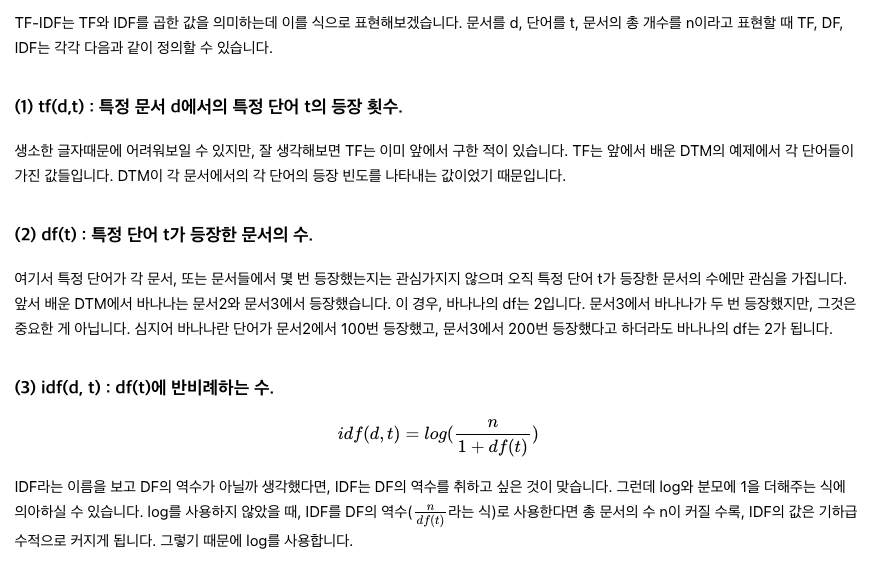

In [80]:
tfidf_vectorizer = TfidfVectorizer()

In [81]:
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


In [82]:
X_train_tfidf

<11314x130107 sparse matrix of type '<class 'numpy.float64'>'
	with 1787565 stored elements in Compressed Sparse Row format>

In [83]:
for v in X_train_tfidf[0] : 
    print(v)

  (0, 86580)	0.13157118714240987
  (0, 128420)	0.04278499079283093
  (0, 35983)	0.03770448563619875
  (0, 35187)	0.09353930598317124
  (0, 66098)	0.09785515708314481
  (0, 114428)	0.05511105154696676
  (0, 78955)	0.05989856888061599
  (0, 94362)	0.055457031390147224
  (0, 76722)	0.06908779999621749
  (0, 57308)	0.1558717009157704
  (0, 62221)	0.02921527992427867
  (0, 128402)	0.05922294083277842
  (0, 67156)	0.07313443922740179
  (0, 123989)	0.08207027465330353
  (0, 90252)	0.031889368795417566
  (0, 63363)	0.08342748387969037
  (0, 78784)	0.0633940918806495
  (0, 96144)	0.10826904490745741
  (0, 128026)	0.060622095889758885
  (0, 109271)	0.10844724822064673
  (0, 51730)	0.09714744057976722
  (0, 86001)	0.07000411445838192
  (0, 83256)	0.08844382496462173
  (0, 113986)	0.17691750674853082
  (0, 37565)	0.03431760442478462
  :	:
  (0, 4605)	0.06332603952480323
  (0, 76032)	0.019219463052223086
  (0, 92081)	0.09913274493911223
  (0, 40998)	0.0780136819691811
  (0, 79666)	0.109364012524142

# 가우시안 나이브 베이즈

* 입력 특성이 가우시안(정규) 분포를 갖는다고 가정

### 학습 및 평가

In [84]:
model = GaussianNB()
model.fit(covtype_X_train_scale, covtype_y_train)

GaussianNB()

In [85]:
predict = model.predict(covtype_X_train_scale)
accuracy = metrics.accuracy_score(covtype_y_train, predict)
f1 = metrics.f1_score(covtype_y_train, predict, average=None)

print('Train Accuracy : {}' .format(accuracy))
print('Train F1 Score: {}' .format(f1))

Train Accuracy : 0.08824484895946506
Train F1 Score: [0.04072125 0.01809449 0.33534041 0.13812606 0.04371444 0.06629323
 0.23503586]


In [86]:
predict = model.predict(covtype_X_test_scale)
accuracy = metrics.accuracy_score(covtype_y_test, predict)
f1 = metrics.f1_score(covtype_y_test, predict, average=None)

print('Test Accuracy : {}' .format(accuracy))
print('Test F1 Score: {}' .format(f1))

Test Accuracy : 0.08727829746219977
Test F1 Score: [0.0392863  0.01737644 0.33357245 0.13923409 0.04222655 0.07472438
 0.23437404]


### 시각화

In [87]:
def make_meshgrid(x, y, h=0.2) :
    x_min, x_max = x.min()-1, x.max()+1
    y_min, y_max = y.min()-1, y.max()+1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy 

def plot_contours(clf, xx, yy, **params) :
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx. shape)
    out = plt.contourf(xx, yy, Z, **params)
    return out 

In [88]:
X, y = make_blobs(n_samples=1000) # 임의로 1000개의 샘플 생성(토양 데이터는 너무 많기 때문에)

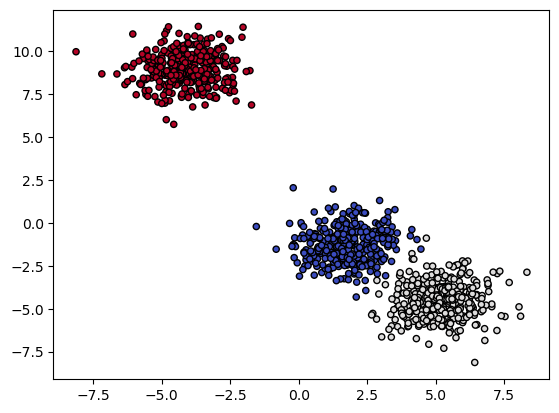

In [89]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')

In [90]:
model = GaussianNB()
model.fit(X, y)

GaussianNB()

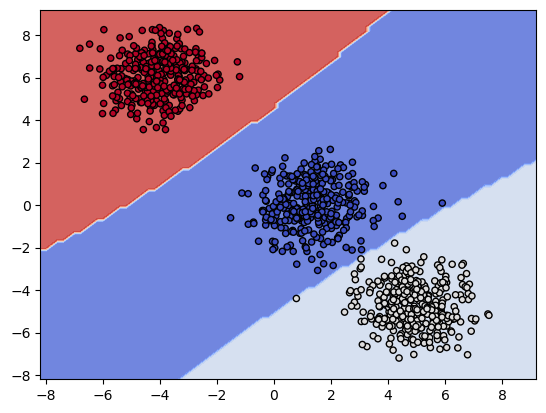

In [ ]:
xx, yy = make_meshgrid(X[:, ], X[:, 1])
plot_contours(model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k');

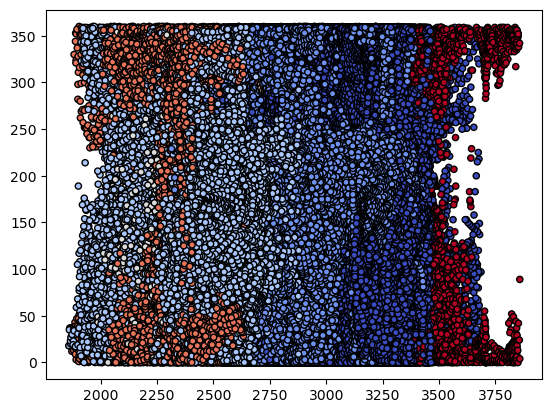

In [ ]:
# 토양 데이터는 개수가 매우 많기 때문에 시각화로 나타내기에는 무리가 있다.
# 아래와 같이 되기 때문에, make_blobs()를 사용한 것임.
plt.scatter(covtype_X[:, 0], covtype_X[:, 1], c=covtype_y, cmap=plt.cm.coolwarm, s=20, edgecolors='k');

# 베르누이 나이브 베이즈
* 입력 특성이 베르누이 분포에 의해 생성된 이진 값을 갖는다고 가정

In [91]:
model = BernoulliNB()
model.fit(X_train_count, y_train)

BernoulliNB()

In [92]:
predict = model.predict(X_train_count)
accuracy = metrics.accuracy_score(y_train, predict)
f1 = metrics.f1_score(y_train, predict, average=None)
print('Train Accuracy : {}' .format(accuracy))
print('Train F1 Score: {}' .format(f1))

Train Accuracy : 0.7821283365741559
Train F1 Score: [0.80096502 0.8538398  0.13858268 0.70686337 0.85220126 0.87944493
 0.51627694 0.84532672 0.89064976 0.87179487 0.94561404 0.91331546
 0.84627832 0.89825848 0.9047619  0.79242424 0.84693878 0.84489796
 0.67329545 0.14742015]


In [93]:
predict = model.predict(X_test_count)
accuracy = metrics.accuracy_score(y_test, predict)
f1 = metrics.f1_score(y_test, predict, average=None)
print('test Accuracy : {}' .format(accuracy))
print('test F1 Score: {}' .format(f1))

test Accuracy : 0.6307753584705258
test F1 Score: [0.47086247 0.60643564 0.01       0.56014047 0.6953405  0.70381232
 0.44829721 0.71878646 0.81797753 0.81893491 0.90287278 0.74794521
 0.61647059 0.64174455 0.76967096 0.63555114 0.64285714 0.77971474
 0.31382979 0.00793651]


## 학습 및 평가(Hash)

In [95]:
model = BernoulliNB()
model.fit(X_train_hash, y_train)

BernoulliNB()

In [96]:
predict = model.predict(X_train_hash)
accuracy = metrics.accuracy_score(y_train, predict)
f1 = metrics.f1_score(y_train, predict, average=None)
print('Train Accuracy : {}' .format(accuracy))
print('Train F1 Score: {}' .format(f1))

Train Accuracy : 0.5951917977726711
Train F1 Score: [0.74226804 0.49415205 0.45039019 0.59878155 0.57327935 0.63929619
 0.35390947 0.59851301 0.72695347 0.68123862 0.79809524 0.70532319
 0.54703833 0.66862745 0.61889927 0.74707471 0.6518668  0.60485269
 0.5324165  0.54576271]


In [97]:
predict = model.predict(X_test_hash)
accuracy = metrics.accuracy_score(y_test, predict)
f1 = metrics.f1_score(y_test, predict, average=None)
print('test Accuracy : {}' .format(accuracy))
print('test F1 Score: {}' .format(f1))

test Accuracy : 0.4430430164630908
test F1 Score: [0.46678636 0.33826638 0.29391892 0.45743329 0.41939121 0.46540881
 0.34440068 0.46464646 0.62849873 0.53038674 0.63782051 0.55251799
 0.32635983 0.34266886 0.46105919 0.61780105 0.46197991 0.54591837
 0.27513228 0.3307888 ]


## 학습 및 평가(Tf-idf)

In [98]:
model = BernoulliNB()
model.fit(X_train_tfidf, y_train)

BernoulliNB()

In [99]:
predict = model.predict(X_train_tfidf)
accuracy = metrics.accuracy_score(y_train, predict)
f1 = metrics.f1_score(y_train, predict, average=None)
print('Train Accuracy : {}' .format(accuracy))
print('Train F1 Score: {}' .format(f1))

Train Accuracy : 0.7821283365741559
Train F1 Score: [0.80096502 0.8538398  0.13858268 0.70686337 0.85220126 0.87944493
 0.51627694 0.84532672 0.89064976 0.87179487 0.94561404 0.91331546
 0.84627832 0.89825848 0.9047619  0.79242424 0.84693878 0.84489796
 0.67329545 0.14742015]


In [100]:
predict = model.predict(X_test_tfidf)
accuracy = metrics.accuracy_score(y_test, predict)
f1 = metrics.f1_score(y_test, predict, average=None)
print('test Accuracy : {}' .format(accuracy))
print('test F1 Score: {}' .format(f1))

test Accuracy : 0.6307753584705258
test F1 Score: [0.47086247 0.60643564 0.01       0.56014047 0.6953405  0.70381232
 0.44829721 0.71878646 0.81797753 0.81893491 0.90287278 0.74794521
 0.61647059 0.64174455 0.76967096 0.63555114 0.64285714 0.77971474
 0.31382979 0.00793651]


## 시각화

In [101]:
X, y = make_blobs(n_samples=1000) # 데이터 양이 많아서 make_blobs으로 1000개의 임의 샘플 생성

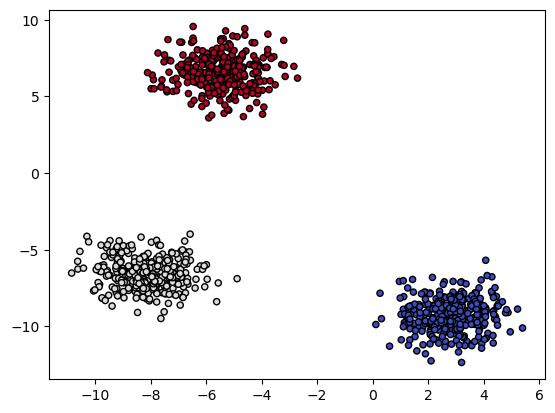

In [102]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')

In [103]:
model = BernoulliNB()
model.fit(X, y)

BernoulliNB()

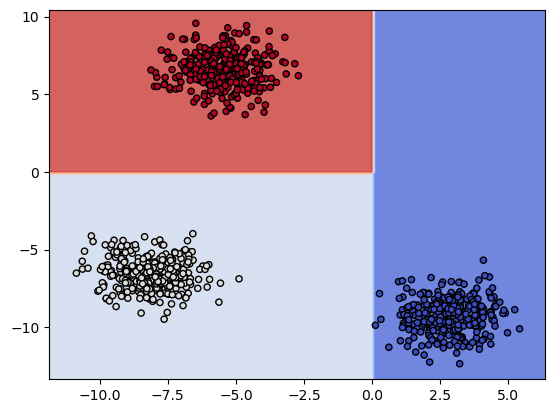

In [104]:
xx, yy = make_meshgrid(X[:, 0], X[:, 1])
plot_contours(model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')

# 다항 나이브 베이즈

* 입력 특성이 다항분포에 의해 생성된 빈도수 값을 갖는다고 가정

## 학습 및 평가(Count)

In [105]:
model = MultinomialNB()
model.fit(X_train_count, y_train)

MultinomialNB()

In [106]:
predict = model.predict(X_train_count)
accuracy = metrics.accuracy_score(y_train, predict)
f1 = metrics.f1_score(y_train, predict, average=None)
print('train Accuracy : {}' .format(accuracy))
print('train F1 Score: {}' .format(f1))

train Accuracy : 0.9245182959165635
train F1 Score: [0.95228426 0.904      0.25073746 0.81402003 0.96669513 0.88350983
 0.90710383 0.97014925 0.98567818 0.99325464 0.98423237 0.95399516
 0.95703454 0.98319328 0.98584513 0.95352564 0.97307002 0.97467249
 0.95157895 0.86526946]


In [107]:
predict = model.predict(X_test_count)
accuracy = metrics.accuracy_score(y_test, predict)
f1 = metrics.f1_score(y_test, predict, average=None)
print('test Accuracy : {}' .format(accuracy))
print('test F1 Score: {}' .format(f1))

test Accuracy : 0.7728359001593202
test F1 Score: [0.77901431 0.7008547  0.00501253 0.64516129 0.79178082 0.73370166
 0.76550681 0.88779285 0.93951094 0.91390728 0.94594595 0.78459938
 0.72299169 0.84635417 0.86029412 0.80846561 0.78665077 0.89281211
 0.60465116 0.48695652]


## 학습 및 평가(Tf-idf)

In [108]:
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

MultinomialNB()

In [109]:
predict = model.predict(X_train_tfidf)
accuracy = metrics.accuracy_score(y_train, predict)
f1 = metrics.f1_score(y_train, predict, average=None)
print('train Accuracy : {}' .format(accuracy))
print('train F1 Score: {}' .format(f1))

train Accuracy : 0.9326498143892522
train F1 Score: [0.87404162 0.95414462 0.95726496 0.92863002 0.97812773 0.97440273
 0.91090909 0.97261411 0.98659966 0.98575021 0.98026316 0.94033413
 0.9594478  0.98032506 0.97755611 0.77411003 0.93506494 0.97453907
 0.90163934 0.45081967]


In [110]:
predict = model.predict(X_test_tfidf)
accuracy = metrics.accuracy_score(y_test, predict)
f1 = metrics.f1_score(y_test, predict, average=None)
print('test Accuracy : {}' .format(accuracy))
print('test F1 Score: {}' .format(f1))

test Accuracy : 0.7738980350504514
test F1 Score: [0.63117871 0.72       0.72778561 0.72104019 0.81309686 0.81643836
 0.7958884  0.88135593 0.93450882 0.91071429 0.92917167 0.73583093
 0.69732938 0.81907433 0.86559803 0.60728118 0.76286353 0.92225201
 0.57977528 0.24390244]


## 시각화

In [129]:
X, y = make_blobs(n_samples=1000)

In [130]:
scaler = MinMaxScaler() # 이따가 X의 값이 negative value가 안됌. 따라서 MinMaxScaler()로 전처리.
X = scaler.fit_transform(X)

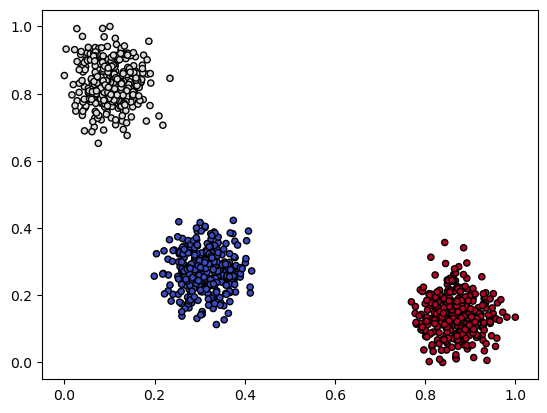

In [131]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')

In [132]:
model = MultinomialNB()
model.fit(X, y)

MultinomialNB()

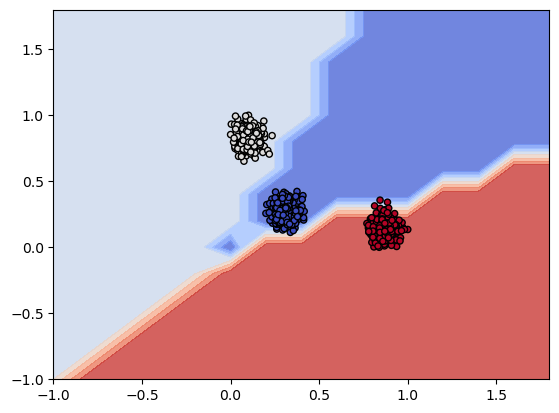

In [133]:
xx, yy = make_meshgrid(X[:, 0], X[:, 1])
plot_contours(model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')